In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

In [4]:
movies_df = pd.read_csv("ml-latest-small/movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df = pd.read_csv("ml-latest-small/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Question 1

In [6]:
total_users = ratings_df.userId.unique()
len(total_users)
all_pos_ratings = len(movies_df) * len(total_users)
sparsity = len(ratings_df) / all_pos_ratings
print("Total number of possible ratings:", all_pos_ratings)
print("Total number of available ratings:", len(ratings_df))
print("Sparsity", sparsity)

Total number of possible ratings: 5942620
Total number of available ratings: 100836
Sparsity 0.016968273253211548


## Question 2

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


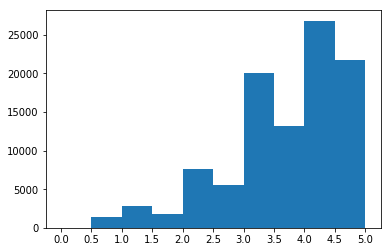

In [7]:
r_bins = [x / 10.0 for x in range(0, 51, 5)]
print(r_bins)
plt.hist(ratings_df.rating, bins=r_bins)
plt.xticks(r_bins)
plt.show()

The distribution is left skewed. People are more willing to rat the movies they like than rating the movies they displike.

## Question 3

In [8]:
movie_ratings = dict()
for i in range(len(ratings_df)):
    id = ratings_df.loc[i, "movieId"]
    if id in movie_ratings:
        movie_ratings[id] = movie_ratings[id] + 1
    else:
        movie_ratings[id] = 1

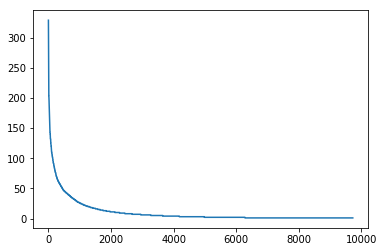

In [9]:
movie_lists = sorted(movie_ratings.items(), key=lambda x:-x[1]) #sorted by key
x_id,y_cnt = zip(*movie_lists)
xs = range(len(x_id))
plt.plot(xs, y_cnt)
plt.show()

## Question 4

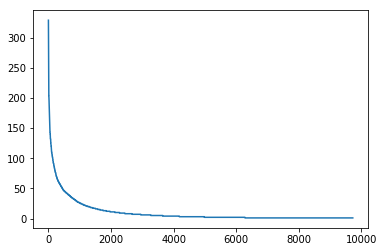

In [10]:
user_cnt = dict()
for i in range(len(ratings_df)):
    id = ratings_df.loc[i, "userId"]
    if id in user_cnt:
        user_cnt[id] = user_cnt[id] + 1
    else:
        user_cnt[id] = 1
user_list = sorted(user_cnt.items(), key=lambda x:-x[1])
user_list
u_id,y_cnt = zip(*movie_lists)
xs = range(len(u_id))
plt.plot(xs, y_cnt)
plt.show()

## Question 5

The distribution has a really long tail, and this means that only a small portion of the movies have lots of ratings most of the movies have a small number of ratings. This means that the matrix is very sparse. The sparse matrix limits the coverage of neighborhood-based methods, and this creates challenges for robust similarity computation.

## Question 6

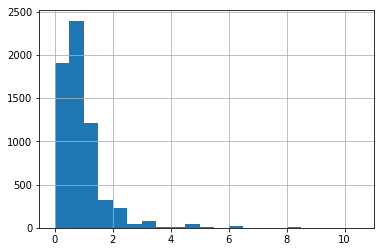

In [11]:
movie_var = ratings_df.groupby(['movieId'])['rating'].var()
movie_var.head()
max_var = movie_var.max()
min_var = movie_var.min()
v_bins = [i / 10.0 for i in range(0, 106, 5)]
movie_var.hist(bins=v_bins)
# plt.xticks(v_bins)
plt.show()

The distribution means that the ratings on the movies are very consistent. Most of the movie have very low variance, and only small amount of movie have high variance in terms of reviews.

## Question 7

$\mu_u = \frac{\Sigma_{k \in I_u}}{|I_u|}$

## Question 8

This means the set of items have been rated both by user u and user v. When the two sets are disjoint these two sets 

## Question 9

In [12]:
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset
from surprise.prediction_algorithms import KNNWithMeans

ModuleNotFoundError: No module named 'surprise'

In [13]:
def knn_filter(data_set, krange):
    mae_results = []
    rmse_results = []

    for i in krange:
        result = cross_validate(KNNWithMeans(k=i, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False),
                                data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

        print(i)
        print("MAE = ", avg_mae)
        print("RMSE = ", avg_rmse)

    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()


reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
krange = range(2, 102, 2)
knn_filter(data_set, krange)

NameError: name 'Reader' is not defined

In [14]:
from surprise.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

ModuleNotFoundError: No module named 'surprise'

In [15]:
def binary_predict(alg, data_set, thresholds):
    training_set, test_set = train_test_split(data_set, test_size = 0.1)
    alg.fit(training_set)
    predictions = alg.test(test_set)
    for t in thresholds:
        binary_preditions = [0 if getattr(pred, 'est') < t else 1 for pred in predictions]
        binary_truth = [getattr(pred, 'r_ui') for pred in predictions]
        fpr, tpr, _ = roc_curve(binary_preditions, binary_truth)
        draw_roc(fpr, tpr)

def draw_roc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('AUC = ', roc_auc)
    
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
thresholds = [2.5, 3.0, 3.5, 4.0]
binary_predict(KNNWithMeans(k=16, sim_options = {'name': 'pearson', 'user_base': True}, verbose=False), data_set, thresholds)

NameError: name 'Reader' is not defined

In [16]:
reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
print(data_set)

NameError: name 'Reader' is not defined

## Question 12

In [18]:
# trim test dataset
popular_movie_df = ratings_df[ratings_df['rating'] > 2]
unpopular_movie_df = ratings_df[ratings_df['rating'] <= 2]
at_least_5_ratings_df = ratings_df.groupby(['movieId']).filter(lambda x: len(x) >= 5)
high_var_df = at_least_5_ratings_df.groupby(['movieId']).filter(lambda x: (x['rating']).var() >= 2)
print(high_var_df.shape)
print (ratings_df.shape)
print (popular_movie_df.shape)
print (unpopular_movie_df.shape)

(586, 4)
(100836, 4)
(87313, 4)
(13523, 4)


## Question 17

In [10]:
# def build_movie_mapping(ratings_df):
#     mapping = {}
#     for idx, row in movies_df.iterrows():
#         movie_id = int(row['movieId'])
#         if movie_id not in mapping:
#             mapping[movie_id] = len(mapping) + 1
#     return mapping

# id_to_col = build_movie_mapping(ratings_df)
# mapping movieId to 1 - 9742



In [11]:
# def build_rating_matrix(num_user, num_movie, rarings_df, mapping):
#     R_matrix = np.zeros((num_user, num_movie))
#     for idx, row in ratings_df.iterrows():
#         user_id, movie_id, rating = int(row['userId']), mapping[int(row['movieId'])], float(row['rating'])
#         R_matrix[user_id-1][movie_id-1] = rating
#     return R_matrix

# print(len(total_users), len(movies_df))
# R_matrix = build_rating_matrix(len(total_users), len(movies_df), ratings_df, id_to_col)


610 9742


In [27]:
from surprise.prediction_algorithms.matrix_factorization import NMF

100836


2
MAE =  0.9616203309936271
RMSE =  1.1437609712659786
4
MAE =  0.8491287236938216
RMSE =  1.038805797617638
6
MAE =  0.7869687909657925
RMSE =  0.9832903837747524
8
MAE =  0.7455003613451122
RMSE =  0.9468202897687089
10
MAE =  0.7251955586568657
RMSE =  0.9302878531917514
12
MAE =  0.7102268800390528
RMSE =  0.9198031768731607
14
MAE =  0.7033949795794989
RMSE =  0.9158753687801763
16
MAE =  0.696801034799028
RMSE =  0.9122713786634818
18
MAE =  0.6951944730006574
RMSE =  0.9140371441160788
20
MAE =  0.6937173926208843
RMSE =  0.9142182671347798
22
MAE =  0.6949271298816658
RMSE =  0.9175064056353012
24
MAE =  0.6955185606574582
RMSE =  0.9204996598316558
26
MAE =  0.6961707814367288
RMSE =  0.9213075886614492
28
MAE =  0.699194936358494
RMSE =  0.9270985018990455
30
MAE =  0.7006730694781724
RMSE =  0.9287511286552285
32
MAE =  0.7031417754772237
RMSE =  0.9331357377637921
34
MAE =  0.706344161412339
RMSE =  0.9373857799791377
36
MAE =  0.7106119920972722
RMSE =  0.942826460739456
3

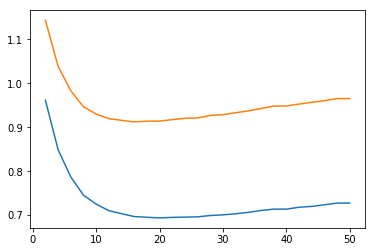

In [32]:
def nnmf_filter(data_set, krange):
    mae_results = []
    min_mae = 99999999999
    min_mae_i = -1

    rmse_results = []
    min_rmse = 9999999999
    min_rmse_i = -1

    for i in krange:
        result = cross_validate(NMF(n_factors=i, biased=False), data_set, measures=['rmse', 'mae'], cv=10, verbose=False)
        avg_mae = np.mean(result['test_mae'])
        avg_rmse = np.mean(result['test_rmse'])
        mae_results.append(avg_mae)
        rmse_results.append(avg_rmse)

        if avg_mae < min_mae:
            min_mae = avg_mae
            min_mae_i = i

        if avg_rmse < min_rmse:
            min_rmse = avg_rmse
            min_rmse_i = i
        print(i)
        print("MAE = ", avg_mae)
        print("RMSE = ", avg_rmse)

    print("Best k for MAE is: ", min_mae_i, "MAE = ", min_mae)
    print("Best k for RMSE is: ", min_rmse_i, "RMSE = ", min_rmse)
    plt.plot(krange, mae_results)
    plt.plot(krange, rmse_results)
    plt.show()


reader = Reader(rating_scale=(0.5, 5))
data_set = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
krange = range(2, 52, 2)
nnmf_filter(data_set, krange)